In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
from sklearn import svm

os.chdir(r'C:\Users\batch_2kjxgc7\Desktop\USF\Courses\DSP\project\trafficsigns')

import warnings
warnings.filterwarnings("ignore")

cur_path = os.getcwd()
cur_path

'C:\\Users\\batch_2kjxgc7\\Desktop\\USF\\Courses\\DSP\\project\\trafficsigns'

In [2]:
data = []
labels = []
classes = 43

for i in range(classes):
    path = os.path.join(cur_path, 'train', str(i))
    images = os.listdir(path)
    
    for a in images:
        try:
            image = Image.open(path + '\\'+ a) 
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image) 
            data.append(image) 
            labels.append(i)
        except:
            print("Error loading image")
            
data = np.array(data)
labels = np.array(labels)

In [3]:
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [4]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(data, labels, test_size=0.9, stratify=labels, random_state=42)

In [5]:
X_test_svm, X_test2_svm, y_test_svm, y_test2_svm = train_test_split(X_test_svm, y_test_svm, test_size=0.97, stratify=y_test_svm, random_state=42)

In [6]:
X_train_svm  = X_train_svm / 255
X_train_svm

array([[[[0.2       , 0.22745098, 0.23529412],
         [0.15294118, 0.14901961, 0.16078431],
         [0.16078431, 0.1372549 , 0.14117647],
         ...,
         [0.13333333, 0.1372549 , 0.14117647],
         [0.15294118, 0.14117647, 0.13333333],
         [0.18823529, 0.15686275, 0.17254902]],

        [[0.20392157, 0.23921569, 0.24313725],
         [0.15294118, 0.15686275, 0.15686275],
         [0.17254902, 0.15686275, 0.15294118],
         ...,
         [0.1372549 , 0.1372549 , 0.14117647],
         [0.16470588, 0.16470588, 0.13333333],
         [0.16078431, 0.16078431, 0.17647059]],

        [[0.17647059, 0.23137255, 0.24705882],
         [0.14509804, 0.16470588, 0.18039216],
         [0.16862745, 0.15686275, 0.16862745],
         ...,
         [0.17647059, 0.18431373, 0.18823529],
         [0.16862745, 0.18039216, 0.16470588],
         [0.17254902, 0.19215686, 0.18823529]],

        ...,

        [[0.35294118, 0.38039216, 0.41960784],
         [0.26666667, 0.2627451 , 0.34901961]

In [7]:
def feature_extraction(X_train):
    image_dataset = pd.DataFrame()
    kernels_main = []

    for image in range(X_train.shape[0]):

        df = pd.DataFrame()

        img = X_train[image, :, :, :]

        pixels = img.reshape(-1)

        #the actual pixel values as the feature
        df["pixel_value"] = pixels

        # Gabor Filters
        num = 1
        kernels = []

        for theta in range(4):
            theta = theta / 4. * np.pi
            for sigma in (1,3):
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)
                ksize = 9
                phi = 0
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype = cv2.CV_32F)
                kernels.append(kernel)
                f_image = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = f_image.reshape(-1)
                df[gabor_label] = filtered_img
                num += 1

        # Sobel Filter Feature
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['sobel'] = edge_sobel1

        # #ROBERTS EDGE
        # edge_roberts = roberts(img)
        # edge_roberts1 = edge_roberts.reshape(-1)
        # df['Roberts'] = edge_roberts1
        
        #SCHARR
        edge_scharr = scharr(img)
        edge_scharr1 = edge_scharr.reshape(-1)
        df['Scharr'] = edge_scharr1
        
        #PREWITT
        edge_prewitt = prewitt(img)
        edge_prewitt1 = edge_prewitt.reshape(-1)
        df['Prewitt'] = edge_prewitt1
        
        #GAUSSIAN with sigma=3
        from scipy import ndimage as nd
        gaussian_img = nd.gaussian_filter(img, sigma=3)
        gaussian_img1 = gaussian_img.reshape(-1)
        df['Gaussian s3'] = gaussian_img1
        
        #GAUSSIAN with sigma=7
        gaussian_img2 = nd.gaussian_filter(img, sigma=7)
        gaussian_img3 = gaussian_img2.reshape(-1)
        df['Gaussian s7'] = gaussian_img3
    
        #MEDIAN with sigma=3
        median_img = nd.median_filter(img, size=3)
        median_img1 = median_img.reshape(-1)
        df['Median s3'] = median_img1
        
        image_dataset = image_dataset.append(df)
        kernels_main  = kernels
    return image_dataset, kernels_main


In [11]:
images_features, kernels = feature_extraction(X_train_svm)

In [12]:
images_features.shape

(10584000, 15)

In [13]:
image_features = np.expand_dims(images_features, axis=0)
X_train = np.reshape(image_features, (X_train_svm.shape[0], -1))

In [14]:
X_train.shape

(3920, 40500)

In [15]:
X_test_svm = X_test_svm/255
test_features, kernels = feature_extraction(X_test_svm)

In [16]:
test_features.shape

(2856600, 15)

In [17]:
test_features = np.expand_dims(test_features, axis=0)
X_test = np.reshape(test_features, (X_test_svm.shape[0], -1))

In [18]:
X_test.shape

(1058, 40500)

In [58]:
matplotlib.use('Agg')
model = RandomForestClassifier()
n_estimators = [200,300, 400 , 500]
max_depth = [30, 35, 40]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train_svm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth for 4.png')

[30, 35, 40]
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best: 0.870153 using {'n_estimators': 700}
0.867857 (0.009324) with: {'n_estimators': 400}
0.865816 (0.012917) with: {'n_estimators': 500}
0.867092 (0.008722) with: {'n_estimators': 600}
0.870153 (0.009711) with: {'n_estimators': 700}


ValueError: cannot reshape array of size 4 into shape (3,4)

In [67]:
RF_model = RandomForestClassifier(n_estimators = 400,random_state = 42)

RF_model.fit(X_train, y_train_svm )

RandomForestClassifier(n_estimators=400, random_state=42)

In [68]:
predicted_values = RF_model.predict(X_test)

In [69]:
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8809073724007561


<AxesSubplot:>

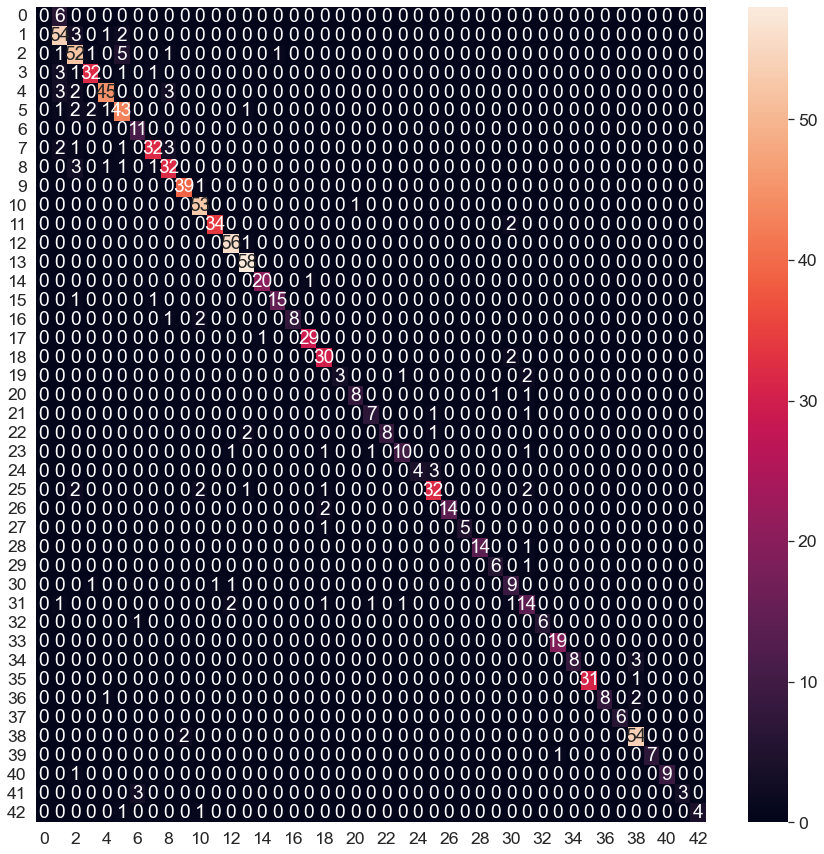

In [70]:
cm = metrics.confusion_matrix(y_test_svm, predicted_values)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

In [10]:
features_list = images_features.columns
features_list

NameError: name 'images_features' is not defined

In [ ]:
RF_model.feature_importances_.shape

(40500,)

In [ ]:
feature_imp = pd.Series(RF_model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

In [17]:
matplotlib.use('Agg')
model = svm.SVC()
kernels = ["poly","rbf"]
coef_0 = [0.5, 1]
degrees = [3,4]
c_s = [5,10]
param_grid = dict(kernel=kernels, coef0=coef_0, degree = degrees , C = c_s)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train_svm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results
# scores = np.array(means).reshape(len(max_depth), len(n_estimators))
# for i, value in enumerate(max_depth):
#     plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
# plt.legend()
# plt.xlabel('n_estimators')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators_vs_max_depth for 4.png')

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [19]:
SVM_model = svm.SVC(kernel="rbf", coef0=0.5, C=10, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8241965973534972


In [20]:
SVM_model = svm.SVC(kernel="rbf", coef0=1, C=100, decision_function_shape='ovo', random_state= 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8629489603024575


In [21]:
SVM_model = svm.SVC(kernel="rbf", coef0=1, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.776937618147448


In [22]:
SVM_model = svm.SVC(kernel="rbf", coef0=0.5, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.776937618147448


In [23]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=1, C=10, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8015122873345936


In [24]:
SVM_model = svm.SVC(kernel="poly",degree=4, coef0=1, C=10, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.7873345935727788


In [25]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=0.5, C=10, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.7457466918714556


In [27]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=1, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.7844990548204159


In [26]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=0.5, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.6994328922495274


In [28]:
SVM_model = svm.SVC(kernel="poly",degree=4, coef0=0.5, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.665406427221172


In [29]:
SVM_model = svm.SVC(kernel="poly",degree=4, coef0=1, C=5, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.775047258979206


In [30]:
SVM_model = svm.SVC(kernel="poly",degree=4, coef0=1, C=20, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.7958412098298677


In [31]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=1, C=50, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8270321361058601


In [32]:
SVM_model = svm.SVC(kernel="poly", degree=3, coef0=1, C=100, decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )

SVC(C=100, coef0=1, decision_function_shape='ovo', kernel='poly',
    random_state=42)

In [33]:
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8298676748582231


In [34]:
SVM_model = svm.SVC(kernel="poly",degree=3, coef0=1, C=200,decision_function_shape='ovo', random_state = 42)  #For multiclass classification
SVM_model.fit(X_train, y_train_svm )
predicted_values = SVM_model.predict(X_test)
accuracy = metrics.accuracy_score(y_test_svm, predicted_values)
print(accuracy)

0.8308128544423441
